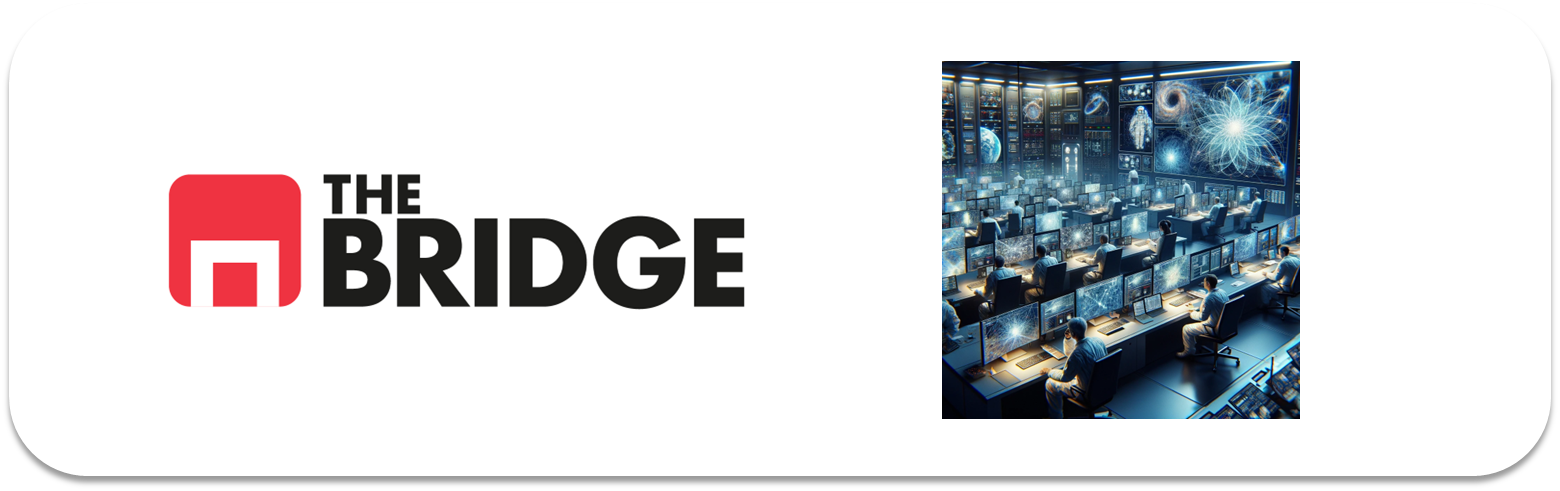

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import cv2
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



# 1. Carga y primer análisis de los datos

In [2]:
ROOT_PATH = './data/'

In [3]:
def read_data(directorio, reshape_dim = (32,32)):
    
    X_train = [] 
    X_test = []
    y_train = []
    y_test = []
    
    for folder in os.listdir(directorio):
        
        print("Leyendo carpeta:", folder)
                
        if os.path.isdir('/'.join([directorio, folder])):
            
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim)

                if folder == "github_test":

                    X_test.append(image)
                    y_test.append(file.split(".")[0])
                                 
                else:

                    X_train.append(image)
                    y_train.append(file.split(".")[0])

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [4]:
X_train, y_train, X_test, y_test = read_data(ROOT_PATH)

Leyendo carpeta: github_test
Leyendo carpeta: github_train_0
Leyendo carpeta: github_train_1
Leyendo carpeta: github_train_2
Leyendo carpeta: github_train_3


In [5]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (4000, 32, 32, 3)
Y train shape:  (4000,)


Tenemos 4000 imagenes de 32x32 de perros y gatos con 3 canales para los colores en train

In [6]:
print('X train shape: ', X_test.shape)
print('Y train shape: ', y_test.shape)

X train shape:  (1000, 32, 32, 3)
Y train shape:  (1000,)


Tenemos 1000 imagenes de 32x32 de perros y gatos con 3 canales para los colores en train

Visualizamos algunas imágenes aleatoriamente

In [7]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    
    for index, paisaje in enumerate(paisajes):
        
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        
        if len(names):
            
            plt.title(names[index])

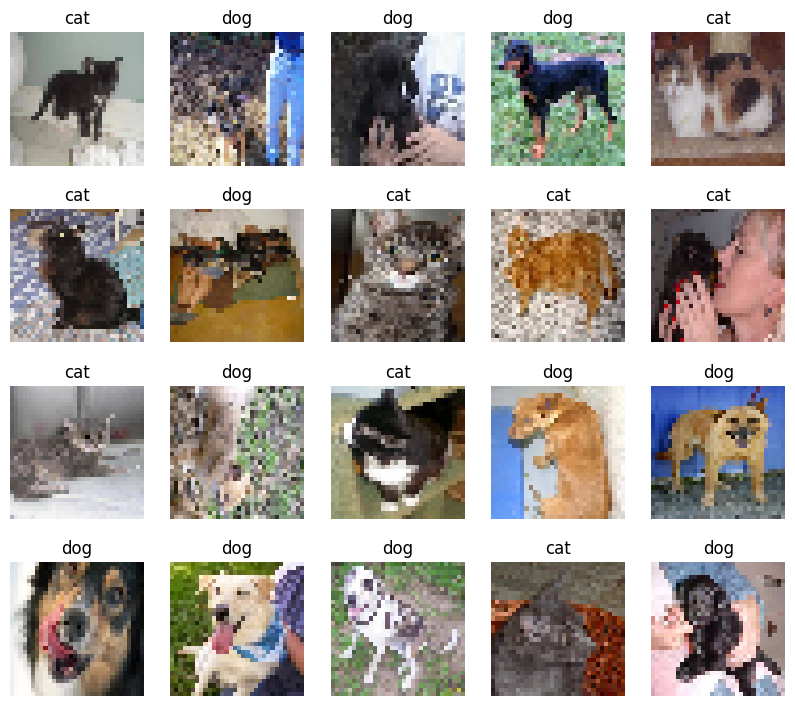

In [8]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

# 2. Proceso EDA y transformación de *features*

En este caso, al tratar con imágenes lo que hacemos es analizar la distribución del *target*

In [9]:
targets = pd.Series(y_train)
targets.value_counts()

cat    2000
dog    2000
Name: count, dtype: int64

Hay dos clases y la distribución está perfectamente balanceada

Normalizamos las imágenes

In [10]:
X_train = X_train/255
X_test = X_test/255

# 3. Modelado

Creamos el modelo DL basado en redes convolucionales con dos juegos Convolutional-Pooling

In [11]:
# Creamos el modelo
model = keras.Sequential()

# Primera capa convolucional y su pooling
model.add(keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (X_train[0].shape), padding = "same", activation = 'relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2)))

# Segunda capa convolucional y su pooling
model.add(keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", activation = 'relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2)))

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
model.add(keras.layers.Flatten())

# Primera capa densa
model.add(keras.layers.Dense(units = 300, activation = 'relu'))

# Capa de salida con 2 neuronas (target binario)
model.add(keras.layers.Dense(units = 2, activation = 'softmax'))

Miramos el tamaño del dataset para escoger el optimizador

In [12]:
X_train.size

12288000

Es un tamaño considerable, por lo que usamos adam con sus hiperparámetros por defecto. En cuanto a la función de pérdida usamos *sparse_categorical_crossentropy* y como métrica, dado el balanceo, el *accuracy*

In [13]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

Visualizamos el modelo creado

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 300)               3

Las imágenes están ordenadas tal y como las hemos leido, así que realizamos un *shuffle* para desordenar la imágenes y evitar que el modelo aprenda el orden

In [15]:
X_train, y_train = shuffle(X_train, y_train)

Convertimos el *target* a ordinal

In [16]:
mapeo = {tipo:indice for indice,tipo in enumerate(targets.unique())}
mapeo

{'cat': 0, 'dog': 1}

In [17]:
y_train_num = np.array([mapeo[y] for y in y_train])
y_test_num = np.array([mapeo[y] for y in y_test])

In [18]:
pd.Series(y_train_num).value_counts()

1    2000
0    2000
Name: count, dtype: int64

Entrenamos el modelo con `patience=10`

In [19]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 32, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)]) # Recupera los pesos de la mejor de las epocas durante el periodo de patience

Epoch 1/100


100/100 [==============================] - 2s 14ms/step - loss: 0.6917 - accuracy: 0.5284 - val_loss: 0.6632 - val_accuracy: 0.6025
Epoch 2/100
100/100 [==============================] - 1s 12ms/step - loss: 0.6301 - accuracy: 0.6525 - val_loss: 0.6251 - val_accuracy: 0.6450
Epoch 3/100
100/100 [==============================] - 1s 12ms/step - loss: 0.5794 - accuracy: 0.6859 - val_loss: 0.5944 - val_accuracy: 0.6687
Epoch 4/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5369 - accuracy: 0.7287 - val_loss: 0.6064 - val_accuracy: 0.6787
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - loss: 0.4959 - accuracy: 0.7556 - val_loss: 0.5692 - val_accuracy: 0.6975
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 0.4537 - accuracy: 0.7803 - val_loss: 0.6603 - val_accuracy: 0.6587
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 0.4239 - accuracy: 0.8037 - val_loss: 0.5989 - val_accurac

Visualizamos la evolución del entrenamiento

In [20]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.691673,0.528437,0.663167,0.60250
1,0.630065,0.652500,0.625080,0.64500
2,0.579434,0.685938,0.594363,0.66875
3,0.536908,0.728750,0.606431,0.67875
4,0.495856,0.755625,0.569159,0.69750
5,0.453698,0.780312,0.660332,0.65875
6,0.423887,0.803750,0.598932,0.69625
7,0.355455,0.842812,0.673454,0.67375
8,0.310173,0.865937,0.726797,0.70250
9,0.256568,0.894375,0.759222,0.70000


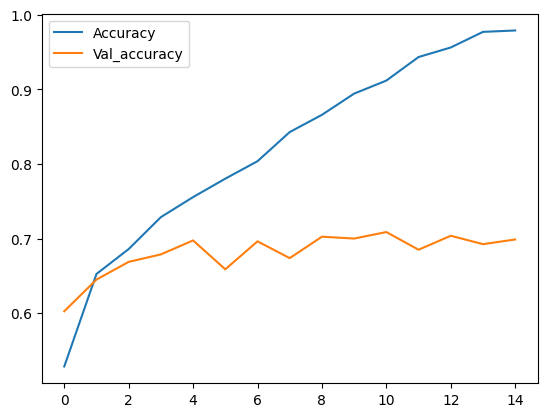

In [21]:
plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val_accuracy')

plt.legend();

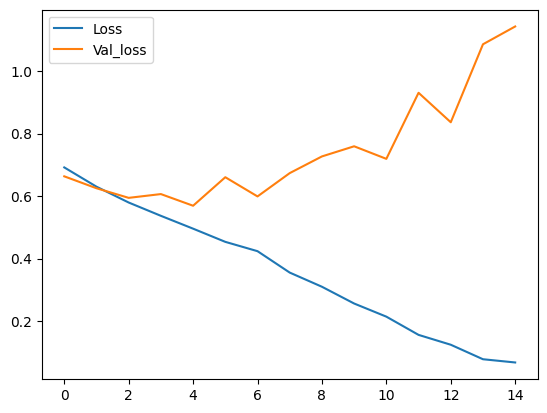

In [22]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend();

A partir de la época 4 lo que se está consiguiendo es hacer *overfitting* y además a partir de la época 8 incluso crece la función de pérdida 

# 4. Evaluación de errores

Evaluamos contra test

In [23]:
resultados = model.evaluate(X_test, y_test_num)
print(f"Obtenemos un accuracy del {round(resultados[1]*100,2)}%")

32/32 [==============================] - 0s 3ms/step - loss: 0.5456 - accuracy: 0.7220
Obtenemos un accuracy del 72.2%


Mostramos el *classification report*

In [24]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

32/32 [==============================] - 0s 3ms/step


In [25]:
# Invertimos la clave y el valor de cada elemento del diccionario
inverse_map = {valor:clave for clave,valor in mapeo.items()}

# Creamos las listas para el classification report y la matriz de confusión
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]

# Mostramos el classification report
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

         cat       0.74      0.68      0.71       500
         dog       0.71      0.76      0.73       500

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



Mostramos la matriz de confusión

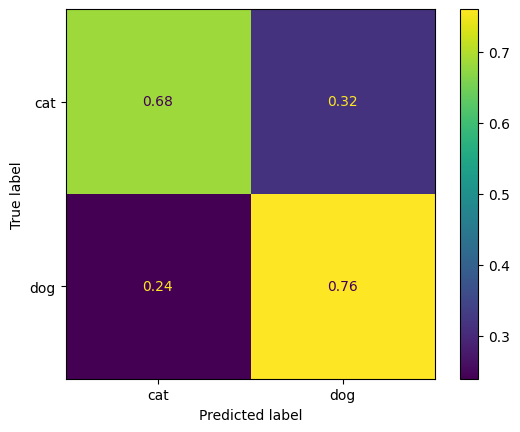

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true");

Tenemos que para los gatos capturamos el 68% y para los perros capturamos el 76%. Sin embargo, el modelo es mas preciso en la clase gatos (74% acierto) que en la clase perros (71% acierto)

# 5. Selección de las imágenes mal clasificadas con mayor confianza

Calculamos las confianzas de cada predicción y creamos un DataFrame filtrado por los errores, ordenado de mayor a menor confianza

In [27]:
# Guardamos las confianzas de predicción para cada imagen
confianza = [prediction.max() for prediction in model.predict(X_test)]

# Creamos el DataFrame
pred_df = pd.DataFrame({"True": y_test_labels, "Predicted": y_pred_labels, "Confianza": confianza})

# Filtramos el 10% de las imagenes clasificadas erróneamente ordenadas de mayor a menor confianza
error = pred_df["True"] != pred_df["Predicted"]
errores = pred_df[error].sort_values("Confianza", ascending = False)
errores = errores.iloc[0:int(0.1*len(errores))]
errores

32/32 [==============================] - 0s 2ms/step


,True,Predicted,Confianza
337,cat,dog,0.984589
893,dog,cat,0.942197
871,dog,cat,0.938296
923,dog,cat,0.933557
368,cat,dog,0.922552
851,dog,cat,0.917796
822,dog,cat,0.915140
16,cat,dog,0.914363
537,dog,cat,0.911591
107,cat,dog,0.901398


Creamos una lista con el nombre de todas las imágenes y la mostramos

In [28]:
folder = "github_test"

# Creamos una lista con todas las imágenes del directorio
lista_imagenes = os.listdir(ROOT_PATH + folder)

# Guardamos los indices del 10% de imágenes seleccionadas
indices_errores = errores.index.to_list()

# Guardamos las imágenes según los índices anteriores
lista_imagenes_mal = []

for indice in indices_errores:
    lista_imagenes_mal.append(lista_imagenes[indice])

print(f"La lista del 10% de imágenes mal clasificadas y filtradas de mayor a menor confianza está compuesta por {len(lista_imagenes_mal)} imágenes:")
lista_imagenes_mal

La lista del 10% de imágenes mal clasificadas y filtradas de mayor a menor confianza está compuesta por 27 imágenes:


['cat.11793.jpg',
 'dog.9530.jpg',
 'dog.9449.jpg',
 'dog.9625.jpg',
 'cat.11899.jpg',
 'dog.9346.jpg',
 'dog.9230.jpg',
 'cat.10747.jpg',
 'dog.8215.jpg',
 'cat.11018.jpg',
 'cat.11669.jpg',
 'cat.11739.jpg',
 'cat.11543.jpg',
 'dog.9691.jpg',
 'cat.11240.jpg',
 'cat.11462.jpg',
 'cat.11636.jpg',
 'dog.8764.jpg',
 'cat.11637.jpg',
 'cat.11535.jpg',
 'cat.11149.jpg',
 'cat.10728.jpg',
 'cat.11644.jpg',
 'dog.8707.jpg',
 'cat.10992.jpg',
 'cat.11411.jpg',
 'cat.12323.jpg']

Visualizamos las imágenes de la lista

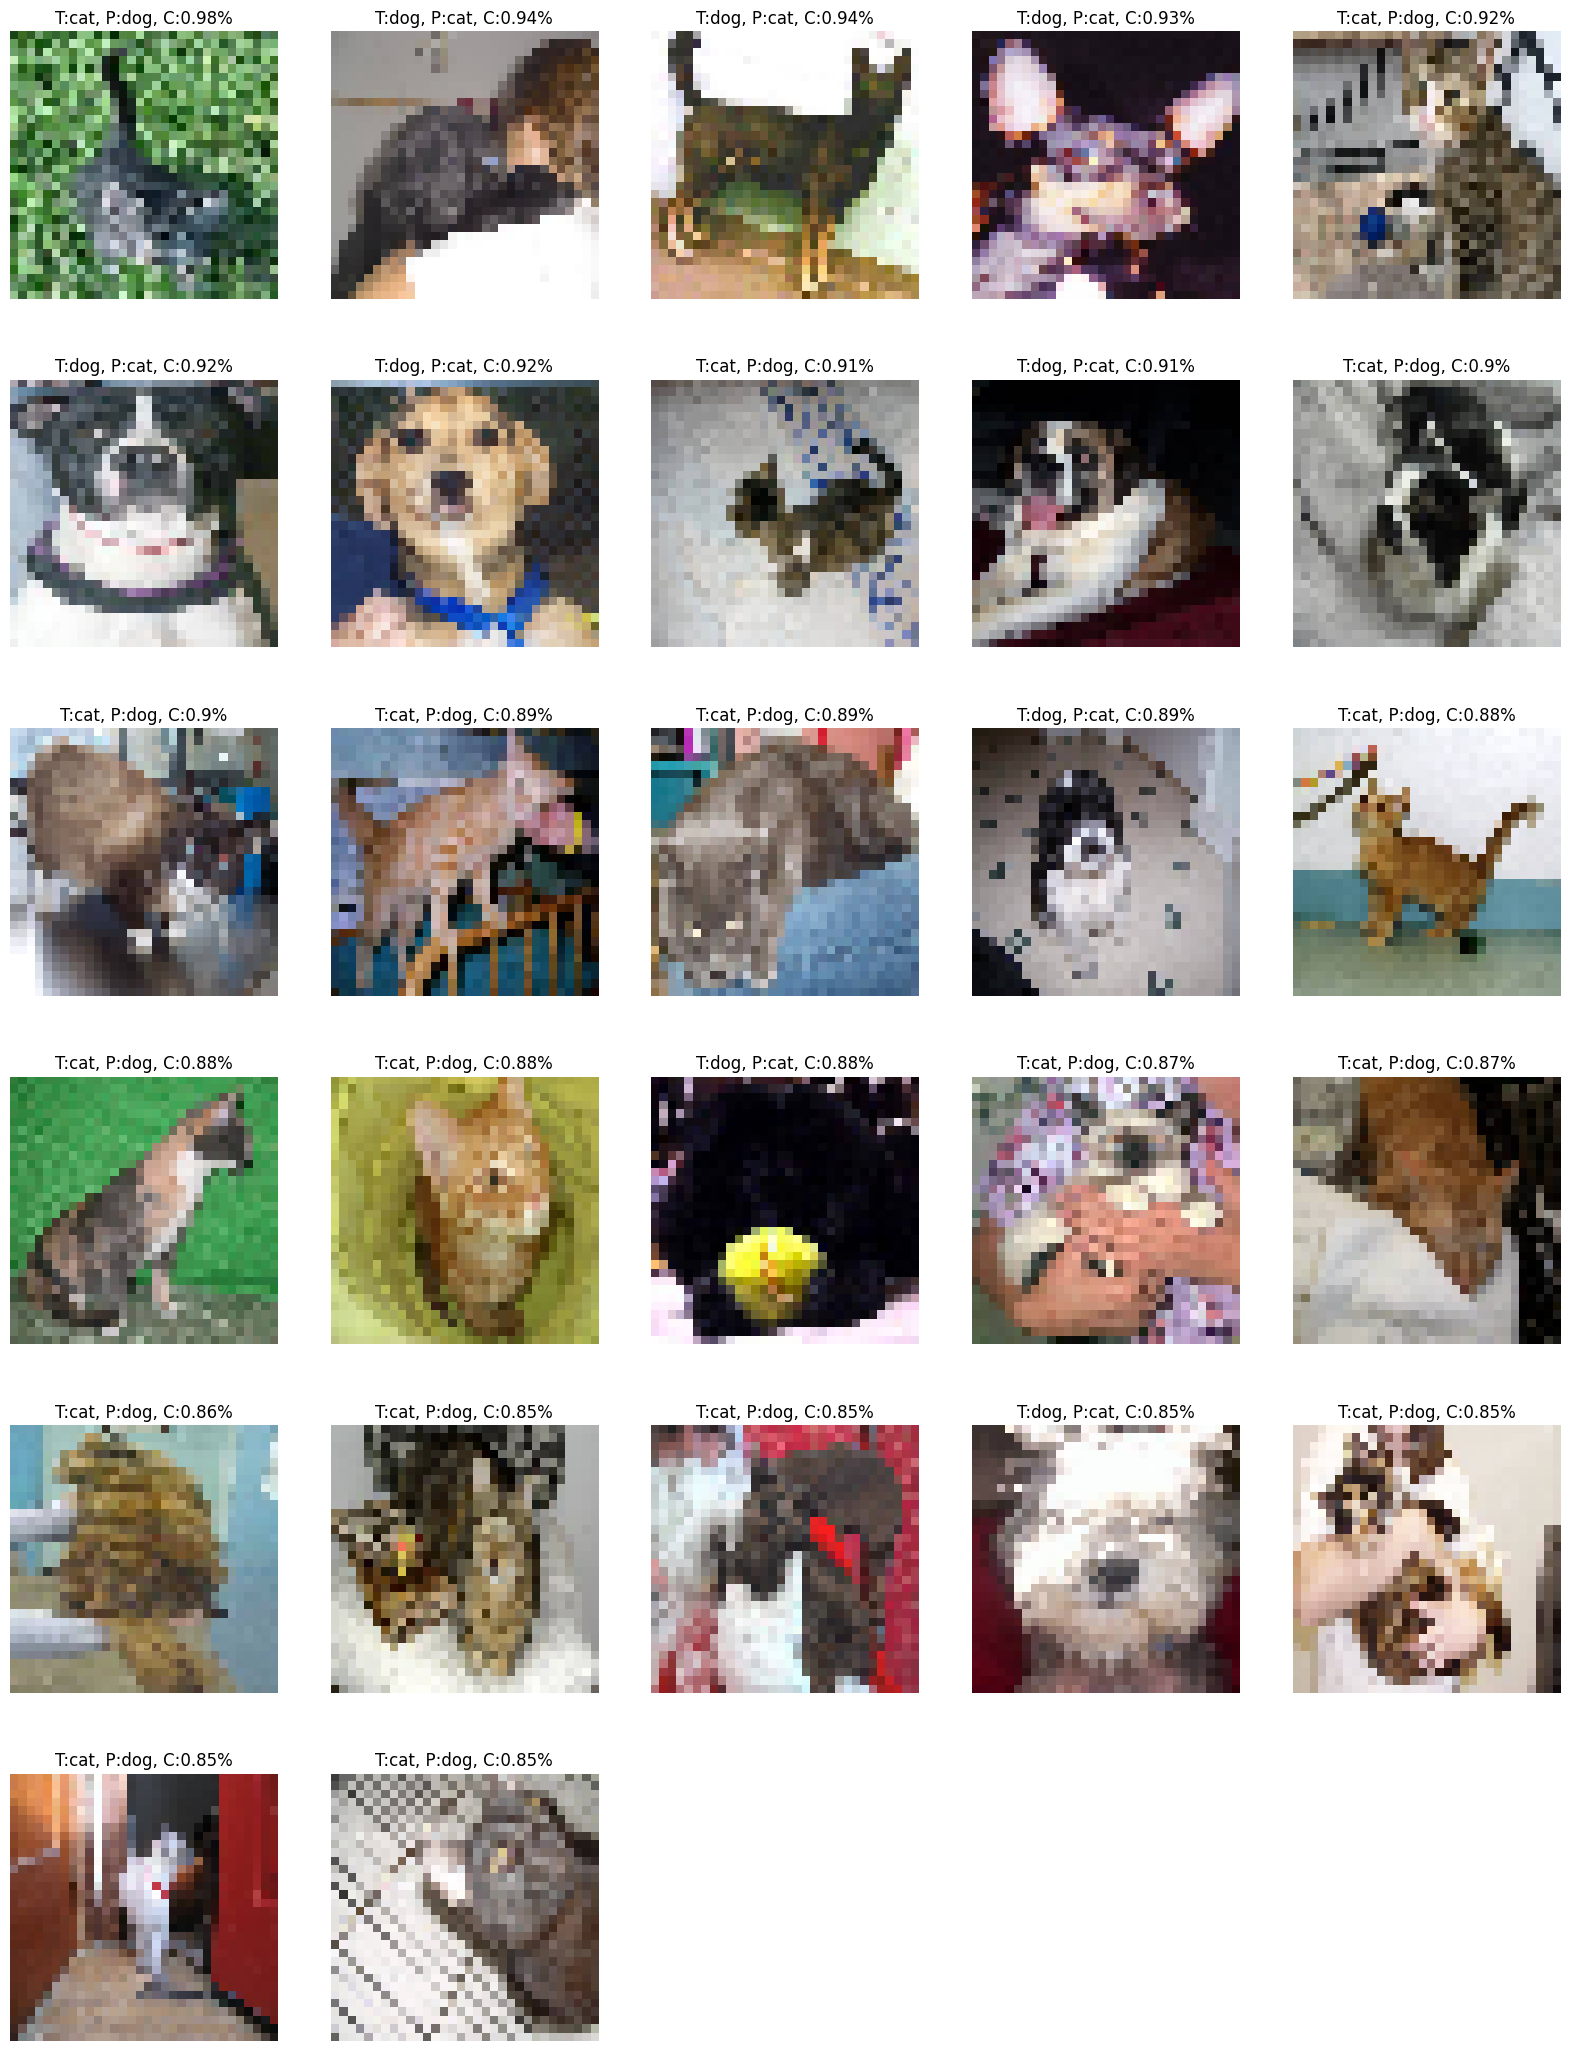

In [29]:
show_images_batch(X_test[errores.iloc[0:len(errores)].index],names= [f"T:{val1}, P:{val2}, C:{round(val3,2)}%" for val1,val2,val3 in errores.iloc[0:len(errores)].values], size_scale= 4)